In [15]:
# Standard DS imports
import pandas as pd
import numpy as np

# Vizualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# NLP imports
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Custom imports
import acquire as a
import env

import os
import requests
import random

## Acquire

In [16]:
df = a.process_all_repos()

In [17]:
df.head()

,Unnamed: 0,repo,language,readme_contents
0,0,/facebookresearch/ResponsibleNLP,Python,This repository hosts code and datasets relati...
1,1,/facebookresearch/projectaria_tools,C++,# Project Aria Tools Project Aria Tools is a ...
2,2,/facebookresearch/HolisticTraceAnalysis,Python,[![CircleCI](https://circleci.com/gh/facebookr...
3,3,/facebookresearch/fairseq2,Python,"<p align=""center""> <img src=""doc/static/img/..."
4,4,/facebookresearch/seamless_communication,Python,![](seamlessM4T.png) # SeamlessM4T SeamlessM4T...


## Prepare

##### Prepare Steps:
- Lowercase All Text
- Remove accented characters and non-ASCII characters
- Remove special characters
- Tokenize
- Lemmatize
- Remove Stopwords
- Add extra Stopwords

In [18]:
df = a.transform_data(df, extra_stopwords=['githubcom', "'"])

In [19]:
df.language.value_counts()

language
Python              676
Jupyter Notebook     80
C++                  38
Markdown             35
TeX                   9
Lua                   9
HTML                  7
Cuda                  7
C                     6
MATLAB                6
Rust                  5
JavaScript            5
TypeScript            3
R                     2
Kotlin                2
Ruby                  1
Java                  1
Shell                 1
Go                    1
C#                    1
Dockerfile            1
Scala                 1
Roff                  1
Coq                   1
SystemVerilog         1
Objective-C++         1
OpenEdge ABL          1
MDX                   1
PureBasic             1
Name: count, dtype: Int64

In [20]:
df.head()

,Unnamed: 0,repo,language,original,clean,lematized
0,0,/facebookresearch/ResponsibleNLP,Python,This repository hosts code and datasets relati...,repository hosts code datasets relating respon...,repository host code datasets relating respons...
1,1,/facebookresearch/projectaria_tools,C++,# Project Aria Tools Project Aria Tools is a ...,project aria tools project aria tools suite c ...,project aria tool project aria tool suite c py...
2,2,/facebookresearch/HolisticTraceAnalysis,Python,[![CircleCI](https://circleci.com/gh/facebookr...,circlecihttps circlecicom gh facebookresearch ...,circlecihttps circlecicom gh appcirclecicom pi...
3,3,/facebookresearch/fairseq2,Python,"<p align=""center""> <img src=""doc/static/img/...",p aligncenter img srcdoc static img logopng wi...,p aligncenter img srcdoc static img logopng wi...
4,4,/facebookresearch/seamless_communication,Python,![](seamlessM4T.png) # SeamlessM4T SeamlessM4T...,seamlessm4tpng seamlessm4t seamlessm4t designe...,seamlessm4tpng seamlessm4t seamlessm4t designe...


## Explore

In [21]:
py_words = ' '.join(df[df.language == 'Python'].lematized)
c_words = ' '.join(df[df.language == 'C++'].lematized)
mark_words = ' '.join(df[df.language == 'Markdown'].lematized)
all_words = ' '.join(df.lematized)

In [22]:
# Get word counts for each language
py_counts =pd.Series(py_words.split()).value_counts()
c_counts =pd.Series(c_words.split()).value_counts()
mark_counts =pd.Series(mark_words.split()).value_counts()
all_counts =pd.Series(all_words.split()).value_counts()

In [23]:
# Get word frequencies for each language
py_freq = pd.Series(py_counts / py_counts.sum())
c_freq = pd.Series(c_counts / c_counts.sum())
mark_freq = pd.Series(mark_counts / mark_counts.sum())
all_freq = pd.Series(all_counts / all_counts.sum())

In [24]:
all_freq.head()

model       0.013175
data        0.007971
python      0.007716
file        0.006444
training    0.006023
Name: count, dtype: float64

In [25]:
# What are the most frequent py words?
py_counts.head(20)

model       5601
python      3270
data        3232
training    2629
file        2503
run         2282
code        2099
td          2072
use         1992
1           1987
dataset     1830
install     1805
license     1675
&#9;        1470
example     1440
using       1425
script      1405
train       1386
http        1322
image       1287
Name: count, dtype: int64

In [26]:
# What are the most frequent c words?
c_counts.head(20)

install      158
model        152
build        144
example      141
game         138
1            124
use          123
python       119
file         118
run          115
c            112
x            101
data         101
see           96
habitat       84
0             82
training      81
cd            80
following     78
bash          76
Name: count, dtype: int64

In [27]:
# What are the most frequent Markdown words?
mark_counts.head(20)

data           156
dataset        134
file           118
contains        88
license         81
participant     80
directory       66
session         56
user            56
audio           55
1               51
model           51
system          45
language        44
paper           43
frame           42
video           41
pose            39
microphone      38
used            35
Name: count, dtype: int64

<div class="alert alert-block alert-info"> 
<b>Takeaway:</b>
    
- Words like 
- Words like 
</div>

In [28]:
#Combine the value counts into one dataframe
word_counts = pd.concat([py_counts, c_counts, mark_counts, all_counts], axis=1)
word_counts.columns = ['py_counts', 'c_counts', 'mark_counts', 'all_counts']

# Fill the nulls with 0
word_counts.fillna(0, inplace=True)
#Recast all columns as integers
word_counts = word_counts.astype('int')

#take a look
word_counts.head()

,py_counts,c_counts,mark_counts,all_counts
model,5601,152,51,6459
python,3270,119,6,3783
data,3232,101,156,3908
training,2629,81,19,2953
file,2503,118,118,3159


In [29]:
#Combine the value counts into one dataframe
word_freq = pd.concat([py_freq, c_freq, mark_freq, all_freq], axis=1)
word_freq.columns = ['py_freq', 'c_freq', 'mark_freq', 'all_freq']

# Fill the nulls with 0
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,py_freq,c_freq,mark_freq,all_freq
model,0.014284,0.006879,0.005229,0.013175
python,0.008339,0.005385,0.000615,0.007716
data,0.008242,0.004571,0.015995,0.007971
training,0.006704,0.003666,0.001948,0.006023
file,0.006383,0.005340,0.012099,0.006444


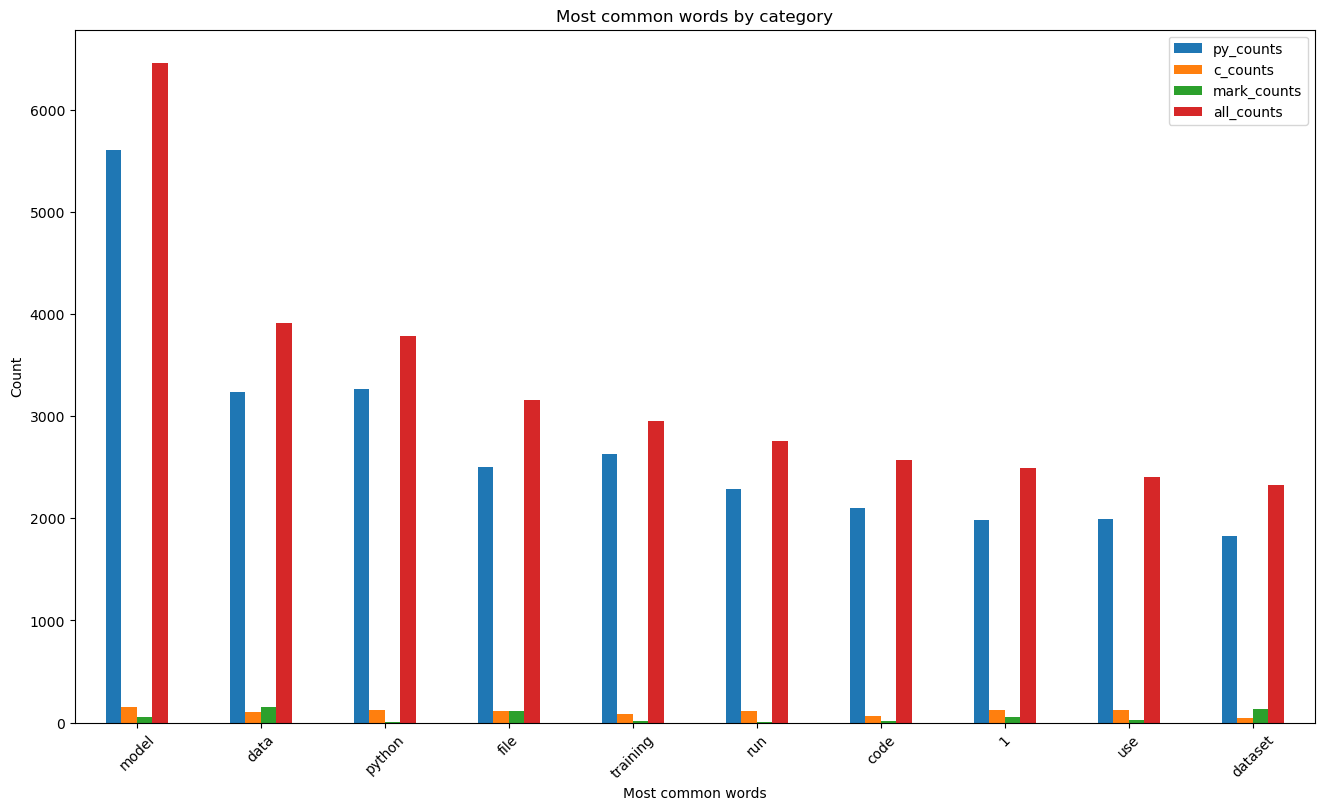

In [30]:
#Plot the most frequent words and color by label
word_counts.sort_values('all_counts', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

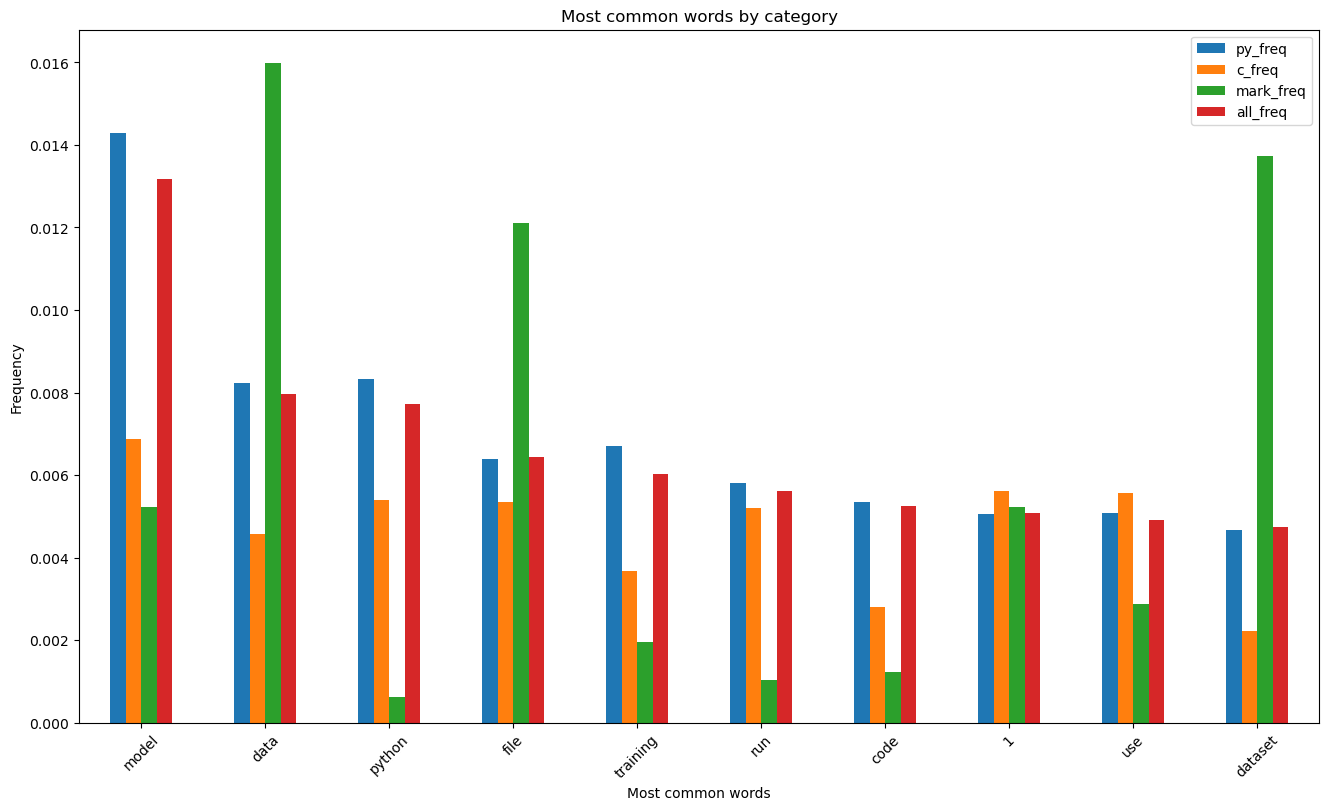

In [31]:
#Plot the most frequent words and color by label
word_freq.sort_values('all_freq', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()